In [1]:
# Two-star-ELS_OSFDM
import numpy as np
import copy
import matplotlib.pyplot as plt
from datetime import datetime

# OSFDM 

In [2]:
def Make_Tridiagonal_Matrix(a, b, c):
    n = len(a)
    U = []
    for j in range(n):
        temp = np.zeros(n)
        temp[j] = a[j]
        if j != 0:
            if j != n - 1:
                temp[j+1] = c[j]
            temp[j-1] = b[j]
        else:
            temp[j+1] = c[j]
        U.append(list(temp))
    return U

def Thomas_algorithm(arr, d):        
    n = len(d)
    a_prime = np.zeros(n)
    d_prime = np.zeros(n)
    x = np.zeros(n)
    
    a_prime[0] = arr[0][0]
    d_prime[0] = d[0]
    
    for i in range(1, n):
        a_prime[i] = arr[i][i] - arr[i-1][i] * (arr[i][i-1] / a_prime[i-1]) 
        d_prime[i] = d[i] - d_prime[i-1] * (arr[i][i-1] / a_prime[i-1])
    
    x[n-1] = d_prime[n-1] / a_prime[n-1]
    
    for j in range(n-2,-1,-1):
        x[j] = (d_prime[j]/a_prime[j]) - (arr[j][j+1]/a_prime[j]) * x[j+1]
    
    return x

In [3]:
############################### Parameters #########################################

# KOSPI200 & Hyundai
# Bank Price = 8331.38
x0 = 100       # reference price of underlying asset 1 (2021/05/06)
y0 = 100       # reference price of underlying asset 2 (2021/05/06)
sig_x = 0.5086 # Volatility of the underlying asset 1
sig_y = 0.2672 # Volatility of the underlying asset 2
rho = 0.6262   # Correlation between prices of the two assets
sigF = 0       # Volatility of exchange rate
rhoF = 0       # Correlation between exchange rate and foreign asset
r = 0.0073     # CD 3-months Interest rate (2021/05/06)
qx = 0.0145    # Dividend of first asset
qy = 0         # Dividend of second asset

############################## Payoff of ELS #######################################

# KOSPI200 & Hyundai
T = 3          # Maturation of contract
cr = np.array([0.025, 0.05, 0.075, 0.10, 0.125, 0.15])  # Coupon rate of return on each early redemption date
K = np.array([0.88, 0.88, 0.85, 0.85, 0.80, 0.80])     # Exercise price on each early redemption date
d = np.array([0.5, 1, 1.5, 2, 2.5, 3])
B = 0.50       # Knock-In barrier level

############################# Spacing ##############################################
dx = x0 * 0.01 # chnage of 1% of current price of asset 1
dy = y0 * 0.01 # chnage of 1% of current price of asset 2
Nx=300          # Number of space(S) points 
Ny=300          # Number of space(S) points
max_x = dx*Nx  # Max price of the underlying asset 1
max_y = dy*Ny  # Max price of the underlying asset 2
min_x = 0      # Min price of the underlying asset 1
min_y = 0      # Min price of the underlying asset 2
pp = 50       # Number of time points in each 6 month
Nt = 6*pp     # Total number of time points (monthly frequency)
dt = T/Nt     # Time step
h = (max_x-min_x)/Nx  # Space(X) step
k = (max_y-min_y)/Ny  # Space(Y) step

x=np.linspace(min_x,max_x,Nx+1)
y=np.linspace(min_y,max_y,Ny+1)

x_tag = np.min(np.where(x == x0))
y_tag = np.min(np.where(y == y0))

In [4]:
def ELS_Twostar_OSFDM(min_x, max_x, min_y, max_y, sig_x, sig_y, rho, sigF, rhoF, rf, qx, qy, x0, y0, cr, K, B, T, pp, Nx, Ny):
    
    Nt = 6*pp
    dt = T/Nt
    h = (max_x - min_x) / Nx  # h=1
    k = (max_y - min_y) / Ny  # k=1
    
    # Computational domain
    x = np.linspace(min_x, max_x, Nx+1)
    y = np.linspace(min_y, max_y, Ny+1)
    
    # Pre-allocation
    u = np.zeros((Nx+1, Ny+1)) # No-knock-in price
    w = np.zeros((Nx+1, Ny+1)) # Knock-in price
    u0 = copy.deepcopy(u)
    w0 = copy.deepcopy(w)
    
    d_ux = np.zeros(Nx-1)
    d_wx = np.zeros(Nx-1)
    
    d_uy = np.zeros(Ny-1)
    d_wy = np.zeros(Ny-1)
    
    # Coefficients of x for the first step of the OS algorithm
    a_x = np.zeros(Nx-1)
    b_x = np.zeros(Nx-1)
    c_x = np.zeros(Nx-1)  
    
    for i in range (1,Nx):
        a_x[i-1] = 1/dt + ( rf/2 + (rf-qx)*x[i]/h + (sig_x*x[i])**2/(h**2) )
        b_x[i-1] = -(sig_x*x[i])**2 /(2*h**2)
        c_x[i-1] = -( (rf-qx)*x[i]/h + (sig_x*x[i])**2 /(2*h**2) )
    
    # Boundary Condition adjusted
    a_x[0] = a_x[0] + 2*b_x[0]
    c_x[0] = c_x[0] - b_x[0]
    b_x[-1] = b_x[-1] - c_x[-1]
    a_x[-1] = a_x[-1] + 2*c_x[-1]
    
    # Coefficient y (for the second step of the OS algorithm)
    a_y = np.zeros(Ny-1)
    b_y = np.zeros(Ny-1)
    c_y = np.zeros(Ny-1)
    
    for i in range (1,Ny):
        a_y[i-1] = 1/dt + ( rf/2 + (rf-qy-rhoF*sigF*sig_y)*y[i]/k + (sig_y*y[i])**2/(k**2) )
        b_y[i-1] = -(sig_y*y[i])**2/(2*k**2)
        c_y[i-1] = -( (rf-qy-rhoF*sigF*sig_y)*y[i]/k + (sig_y*y[i])**2/(2*k**2) )
    
    # Boundary Condition adjusted
    a_y[0] = a_y[0] + 2*b_y[0]
    c_y[0] = c_y[0] - b_y[0]
    b_y[-1] = b_y[-1] - c_y[-1]
    a_y[-1] = a_y[-1] + 2*c_y[-1]
    
    # Initial Condition
    for i in range (Nx+1):
        for j in range (Ny+1):
            if(min(x[i]/x0, y[j]/y0) >= K[5]):
                u0[i,j] = 1+cr[5]
                w0[i,j] = 1+cr[5]
            else:
                if(min(x[i]/x0, y[j]/y0) > B):
                    u0[i,j] = 1+cr[5]
                    w0[i,j] = min(x[i]/x0, y[j]/y0)
                else:
                    u0[i,j] = min(x[i]/x0, y[j]/y0) 
                    w0[i,j] = min(x[i]/x0, y[j]/y0)
    
    u = u0.copy()
    w = w0.copy()
    
    # Linear boundary condition adjusted
    u[0,1:] = 2*u[1,1:] - u[2,1:]
    u[-1,1:] = 2*u[-2,1:] - u[-3,1:]
    u[:,0] = 2*u[:,1] - u[:,2]
    u[:,-1] = 2*u[:,-2] - u[:,-3]
    w[0,1:] = 2*w[1,1:] - w[2,1:]
    w[-1,1:] = 2*w[-2,1:] - w[-3,1:]
    w[:,0] = 2*w[:,1] - w[:,2]
    w[:,-1] = 2*w[:,-2] - w[:,-3]
    
        
    u2 = u.copy()
    w2 = w.copy()
    
    ###################################################### Time loop ###########################################################
    for n in range(1,Nt+1):
        ################################################## x - direction #########################################################
        for j in range(1,Ny):
            for i in range(1,Nx):
                d_ux[i-1] = u[i,j]/dt + rho*sig_x*sig_y*x[i]*y[j]*(u[i+1,j+1] -u[i+1,j-1] -u[i-1,j+1] + u[i-1,j-1])/(8*h*k) 
                d_wx[i-1] = w[i,j]/dt + rho*sig_x*sig_y*x[i]*y[j]*(w[i+1,j+1] -w[i+1,j-1] -w[i-1,j+1] + w[i-1,j-1])/(8*h*k)
            
            u2[1:-1,j] = Thomas_algorithm(Make_Tridiagonal_Matrix(a_x, b_x, c_x), d_ux)
            w2[1:-1,j] = Thomas_algorithm(Make_Tridiagonal_Matrix(a_x, b_x, c_x), d_wx)
        
        # Linear boundary condition
        u2[0,1:] = 2*u2[1,1:] - u2[2,1:]
        u2[-1,1:] = 2*u2[-2,1:] - u2[-3,1:]
        u2[:,0] = 2*u2[:,1] - u2[:,2]
        u2[:,-1] = 2*u2[:,-2] - u2[:,-3]
        w2[0,1:] = 2*w2[1,1:] - w2[2,1:]
        w2[-1,1:] = 2*w2[-2,1:] - w2[-3,1:]
        w2[:,0] = 2*w2[:,1] - w2[:,2]
        w2[:,-1] = 2*w2[:,-2] - w2[:,-3]
        
        ################################################## y - direction #########################################################
        for i in range(1,Nx):
            for j in range(1,Ny):
                d_uy[j-1] = u2[i,j]/dt + rho*sig_x*sig_y*x[i]*y[j]*(u2[i+1,j+1] -u2[i+1,j-1] -u2[i-1,j+1] + u2[i-1,j-1])/(8*h*k)
                d_wy[j-1] = w2[i,j]/dt + rho*sig_x*sig_y*x[i]*y[j]*(w2[i+1,j+1] -w2[i+1,j-1] -w2[i-1,j+1] + w2[i-1,j-1])/(8*h*k)
            
            u[i,1:-1] = Thomas_algorithm(Make_Tridiagonal_Matrix(a_y, b_y, c_y), d_uy)
            w[i,1:-1] = Thomas_algorithm(Make_Tridiagonal_Matrix(a_y, b_y, c_y), d_wy)
        
        # Linear boundary condition
        u[0,1:] = 2*u[1,1:] - u[2,1:]
        u[-1,1:] = 2*u[-2,1:] - u[-3,1:]
        u[:,0] = 2*u[:,1] - u[:,2]
        u[:,-1] = 2*u[:,-2] - u[:,-3]
        w[0,1:] = 2*w[1,1:] - w[2,1:]
        w[-1,1:] = 2*w[-2,1:] - w[-3,1:]
        w[:,0] = 2*w[:,1] - w[:,2]
        w[:,-1] = 2*w[:,-2] - w[:,-3]
        
        # Update u as w for knock-in area
        barrier_x = np.min(np.where(x/x0 >= B))
        barrier_y = np.min(np.where(y/y0 >= B))
        u[:,1:(barrier_y+1)] = w[:,1:(barrier_y+1)]
        u[1:(barrier_x+1),:] = w[1:(barrier_x+1),:]
        
        ##################################################### Early redemption ###################################################
        if(n % pp == 0 and n < Nt):
            for i in range(Nx+1):
                for j in range(Ny+1):
                    if(min(x[i]/x0, y[j]/y0) >= K[5-int(n/pp)]):
                        u[i,j] = 1 + cr[5-int(n/pp)]
                        w[i,j] = 1 + cr[5-int(n/pp)]
        
        #if(n%5==0):
        #    print("Time step : ", n)
                        
    return u

In [5]:
price = ELS_Twostar_OSFDM(min_x, max_x, min_y, max_y, sig_x, sig_y, rho, sigF, rhoF, r, qx, qy, x0, y0, cr, K, B, T, pp, Nx, Ny)

In [6]:
face = 10000
print("ELS Price using OSFDM method: ", price[x_tag-1,y_tag-1]*face)

ELS Price using OSFDM method:  8385.558435489078


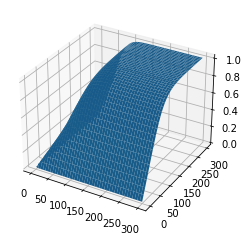

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(min_x, max_x, Nx + 1)
y = np.linspace(min_y, max_y, Ny + 1)
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, price)

# Greeks

##### - Delta

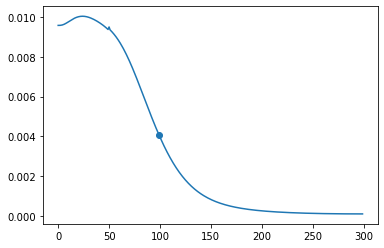

In [8]:
delta_x = (price[1:, y_tag-1] - price[:-1, y_tag-1]) / dx
plt.plot(x[:-1], delta_x)
plt.scatter(x[x_tag-1], delta_x[x_tag-1])
plt.show()

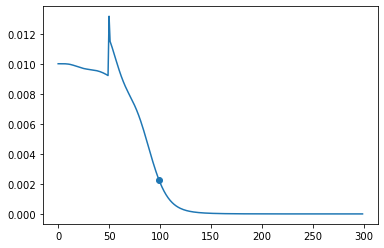

In [9]:
delta_y = (price[x_tag-1, 1:] - price[y_tag-1, :-1]) / dy
plt.plot(y[:-1], delta_y)
plt.scatter(y[y_tag-1], delta_y[y_tag-1])
plt.show()

##### - Gamma

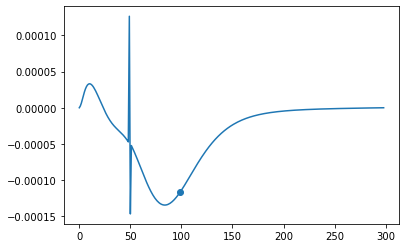

In [10]:
gamma_x = (delta_x[1:] - delta_x[:-1]) / dx
plt.plot(x[:-2], gamma_x)
plt.scatter(x[x_tag-1], gamma_x[x_tag-1])
plt.show()

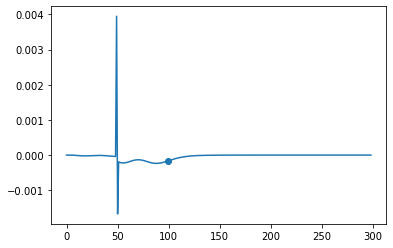

In [11]:
gamma_y = (delta_y[1:] - delta_y[:-1]) / dy
plt.plot(y[:-2], gamma_y)
plt.scatter(y[y_tag-1], gamma_y[y_tag-1])
plt.show()

##### - Vega

In [12]:
price_sig_x = ELS_Twostar_OSFDM(min_x, max_x, min_y, max_y, sig_x+0.01, sig_y, rho, sigF, rhoF, r, qx, qy, x0, y0, cr, K, B, T, pp, Nx, Ny)
price_sig_y = ELS_Twostar_OSFDM(min_x, max_x, min_y, max_y, sig_x, sig_y+0.01, rho, sigF, rhoF, r, qx, qy, x0, y0, cr, K, B, T, pp, Nx, Ny)

In [13]:
vega_x = (price_sig_x - price) / 1
vega_y = (price_sig_y - price) / 1

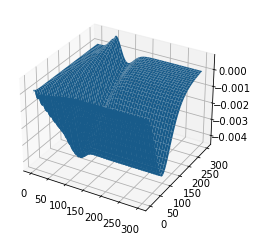

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(min_x, max_x, Nx + 1)
y = np.linspace(min_y, max_y, Ny + 1)
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, vega_x)

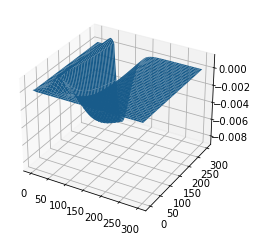

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(min_x, max_x, Nx + 1)
y = np.linspace(min_y, max_y, Ny + 1)
X, Y = np.meshgrid(x, y)

ax.plot_surface(X, Y, vega_y)

In [16]:
print("Price : ", price[x_tag-1, y_tag-1])
print("Delta of Hyundai: ", delta_x[x_tag-1])
print("Delta of KOSPI200: ", delta_y[y_tag-1])
print("Gamma of Hyundai: ", gamma_x[x_tag-1])
print("Gamma of KOSPI200: ", gamma_y[y_tag-1])
print("Vega of Hyundai: ", vega_x[x_tag-1, y_tag-1])
print("Vega of KOSPI200: ", vega_y[x_tag-1, y_tag-1])

Price :  0.8385558435489078
Delta of Hyundai:  0.004073957655531313
Delta of KOSPI200:  0.0022707042918455045
Gamma of Hyundai:  -0.00011597498327931
Gamma of KOSPI200:  -0.00017010427759234226
Vega of Hyundai:  -0.004109179483497538
Vega of KOSPI200:  -0.0022700835715930845


# Simulation (Using Brownian Bridge)

In [17]:
import numpy as np
def BB(w0,wt,t,m):
    h = 2**m
    T = np.linspace(0,t, h+1)
    W = np.zeros(h+1)
    z = np.random.randn(h+1)
    W[0] = w0
    W[h] = wt
    j_max = 1
    
    for k in range(1, m+1):
        i_min = h//2
        i = i_min
        l = 0
        r = h
        for j in range(1, j_max+1):
            a = ((T[r]-T[i])*W[l] + (T[i]-T[l])*W[r]) / (T[r]-T[l])
            b = np.sqrt( (T[i]-T[l])*(T[r]-T[i])/(T[r]-T[l]) )
            W[i] = a + b*z[i]
            i+=h; l+=h; r+=h
        j_max*=2
        h = i_min
    
    return W

In [18]:
import numpy as np
def ELS_BB(x0,y0,r,q1,q2,sigma1,sigma2,rho,T,cr,K,B,M,m):
    
    S1_start = x0
    S2_start = y0
    principal = 10000
    
    T = 3
    check_term = 0.5
    check_max = int(T / check_term)
    
    case=8
    S1 = np.zeros(check_max+1)
    S2 = np.zeros(check_max+1)
    payment = np.zeros(M)
    prob = np.zeros(case)
    
    for i in range(M):
        
        S1[0] = S1_start
        S2[0] = S2_start
        
        x1 = np.random.randn(check_max)
        x2 = np.random.randn(check_max)
        W1 = np.zeros(check_max+1)
        W2 = np.zeros(check_max+1)

        check_barrier = False
        
        for j in range(1, check_max+1):

            # Random walk
            W1[j] = W1[j-1] + np.sqrt(check_term) * x1[j-1]
            W2[j] = W2[j-1] + np.sqrt(check_term) * x2[j-1]
            
            e1 =  W1[j] - W1[j-1]
            e2 = rho*e1 + (W2[j] - W2[j-1])*np.sqrt(1-rho**2)
    
            S1[j] = S1[j-1]*np.exp( (r - q1 - (sigma1**2)/2)*check_term + sigma1*e1)
            S2[j] = S2[j-1]*np.exp( (r - q2 - (sigma2**2)/2)*check_term + sigma2*e2)
            
            # Check Barrier
            if (S1[j] < S1_start * B) or (S2[j] < S2_start * B):
                check_barrier = True
            
            # Check early repayment
            if (S1[j] >= S1_start * K[j-1]) and (S2[j] >= S2_start * K[j-1]):
                payment[i] = principal * (1+cr[j-1]) * np.exp(-r * j * check_term)
                prob[j-1]+=1
                break
            
            # Check Maturity repayment
            if j == check_max:
                if (check_barrier == True) and ( (S1[j] < S1_start * K[j-1]) or (S2[j] < S2_start * K[j-1]) ):
                    payment[i] = principal * min(S1[j]/S1_start, S2[j]/S2_start) * np.exp(-r * j * check_term)
                    prob[j+1]+=1
                    break
                    
                else:
                    S1_BB = np.zeros(2**m+1)
                    S2_BB = np.zeros(2**m+1)
                    S1_BB[0] = S1_start
                    S2_BB[0] = S2_start
                    
                    # Brownian Bridge
                    for k in range(1, check_max+1):      
                        W1_BB = BB(W1[k-1], W1[k], 0.5, m)
                        W2_BB = BB(W2[k-1], W2[k], 0.5, m)
                        
                        for l in range(1, 2**m+1):
                            e1 = W1_BB[l] - W1_BB[l-1]
                            e2 = rho*e1 + (W2_BB[l] - W2_BB[l-1]) * np.sqrt(1-rho**2)
                        
                            S1_BB[l] = S1_BB[l-1] * np.exp( (r - q1 - sigma1**2/2)*(check_term/2**m) + sigma1 * e1 )
                            S2_BB[l] = S2_BB[l-1] * np.exp( (r - q2 - sigma2**2/2)*(check_term/2**m) + sigma2 * e2 )
                        
                            if(S1_BB[l] < S1_start * B) or (S2_BB[l] < S2_start * B):
                                check_barrier = True
                                payment[i] = principal * min(S1[j]/S1_start, S2[j]/S2_start) * np.exp(-r * j * check_term)
                                prob[j+1]+=1
                                break
                                
                        if check_barrier:
                            break          
                        else:        
                            S1_BB[0] = S1_BB[2**m]
                            S2_BB[0] = S2_BB[2**m]
                    
                    if check_barrier == False:
                        payment[i] = principal * (1+cr[j-1]) * np.exp(-r * j * check_term)
                        prob[j]+=1
                        break
            
    
    value = np.mean(payment)
    prob = prob / M
    
    return value,prob

In [20]:
M=10000
m=3
t1=datetime.now()
value,prob=ELS_BB(x0,y0,r,qx,qy,sig_x,sig_y,rho,T,cr,K,B,M,m)
t2=datetime.now()
print('Simulation Price = {:.2f}'.format(value))
for i in range(8):
    print('prob[{:d}] = {:{width}.2%}'.format(i+1,prob[i],width=6))
print('Total sum of prob = {:.0%}'.format(sum(prob)))
print('Total computing time = {:f} seconds'.format((t2-t1).total_seconds()))

Simulation Price = 8358.51
prob[1] = 49.46%
prob[2] =  9.22%
prob[3] =  5.21%
prob[4] =  2.44%
prob[5] =  2.30%
prob[6] =  1.52%
prob[7] =  1.17%
prob[8] = 28.68%
Total sum of prob = 100%
Total computing time = 0.551556 seconds
